<a href="https://colab.research.google.com/github/pablovitoria/business_analysis_structured_data/blob/main/scripts/A1%3A%20Modeling%20Case%20Study%20-%20Bike%20Rentals%20in%20Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXECUTIVE SUMMARY

Some qualitative info:
"Service alert: Due to the upcoming subzero temperatures forecasted, some ebikes and scooters may be unavailable for use. Classic bikes availability shouldn’t be impacted." Currently on the website

ANSWER TO FIRST QUESTION
Based on your analysis, are the majority of rentals for leisure, exercise, or commuting to work? Provide data-driven evidence for your claim, as well as at least one source from external research.

* Quick intro on how succesful (A Tale of Two Divvys: The Bicycle Sharing System of Chicago — Bergman (2024, Sustainability).)

*




In [1]:
# Notebook set-up
# Cloning GitHub Repo
!git clone https://github.com/pablovitoria/business_analysis_structured_data

# Changing directory
import os
repo_name = '/content/business_analysis_structured_data'
os.chdir(repo_name)

# Checking results
print(f"Current working directory changed to: {os.getcwd()}")

Cloning into 'business_analysis_structured_data'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 72 (delta 36), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 476.94 KiB | 8.37 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Current working directory changed to: /content/business_analysis_structured_data


In [2]:
# importing packages
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # data viz
import seaborn as sns                                # enhanced data viz
import statsmodels.formula.api as smf                # linear modeling
from sklearn.model_selection import train_test_split # train/test split
import sklearn.linear_model                          # faster linear modeling
import numpy as np                                   # mathematical essentials\
import warnings

# Suppressing user warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Storing the path to the dataset
file = "./datasets/bike_rentals.xlsx"


# Reading the file into Python through pandas
bikerentals = pd.read_excel(io = file,
                            usecols = range(1, 15)) # omitting ID column

In [3]:
bikerentals.head()

,Month,Day of Week,Hour,Temperature,Humidity,Wind Speed,Visibility,Dew Point Temperature,UV Index,Rainfall,Snowfall,Seasons,Holiday,RENTALS
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,0.0,Winter,Yes,221
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,0.0,Winter,Yes,130
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,0.0,Winter,Yes,268
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,0.0,Winter,Yes,335
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,0.0,Winter,Yes,299


In [4]:
# Better dataframe readability:
# Making all column names lowercase and replace spaces with underscores
bikerentals.columns = (
                        bikerentals.columns
                        .str.lower()            #lowercase
                        .str.replace(" ", "_")  #replace spaces
                        )

# Making holiday a boolean
bikerentals["holiday"] = (
                          bikerentals["holiday"]
                          .astype(str)
                            .str.strip()
                    .str.lower()
                          .map({"yes": 1, "no": 0}))




In [6]:
bikerentals["holiday"].unique()

array([1, 0])

In [7]:
# Creating new variable to identify working days
# Working day = during the week (not weekend) and not a holiday
# Will be used as a proxy to identify commuters
bikerentals["is_working_day"] = (
    (bikerentals["day_of_week"] != "Saturday") &
    (bikerentals["day_of_week"] != "Sunday") &
    (bikerentals["holiday"] == 0)
).astype(int)

In [14]:
bikerentals[bikerentals["is_working_day"] == 0]

,month,day_of_week,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,snowfall,seasons,holiday,rentals,is_working_day
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,0.0,Winter,1,221,0
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,0.0,Winter,1,130,0
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,0.0,Winter,1,268,0
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,0.0,Winter,1,335,0
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,0.0,Winter,1,299,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,June,Sunday,0,22.9,79,0.6,715,19.0,0.00,0.0,0.0,Summer,0,1030,0
1023,June,Sunday,13,31.2,36,2.0,1022,14.3,2.91,0.0,0.0,Summer,0,1170,0
1024,June,Sunday,15,32.7,31,1.7,1243,13.3,2.30,0.0,0.0,Summer,0,1279,0
1025,June,Sunday,18,30.7,43,1.6,931,16.6,0.74,0.0,0.0,Summer,0,3433,0


In [18]:
bikerentals["is_working_day"].value_counts(dropna=False)


,count
is_working_day,
1,710
0,319


<Axes: xlabel='is_working_day', ylabel='rentals'>

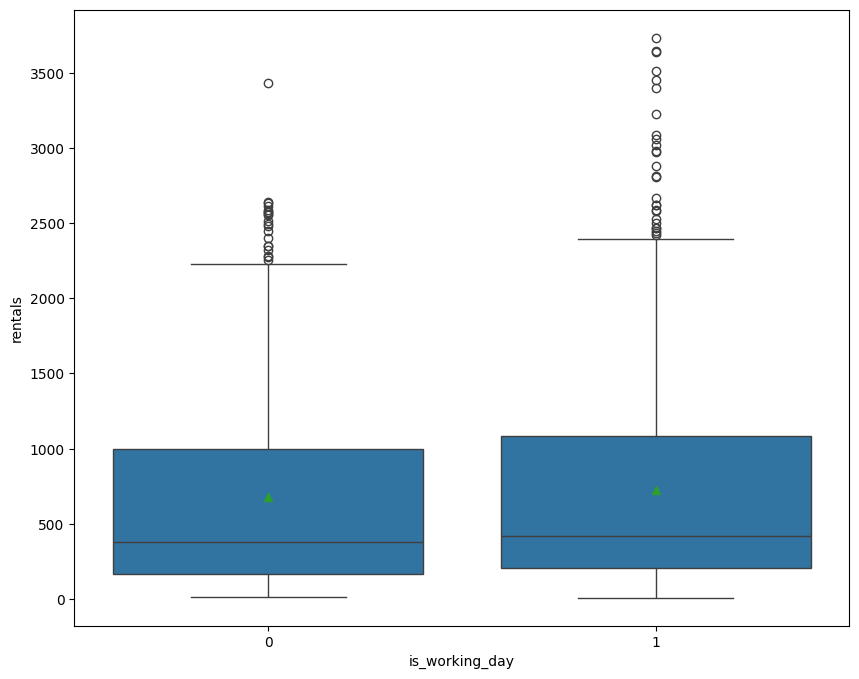

In [16]:
# Understanding if tehre is a difference
fig, ax = plt.subplots(figsize = (10, 8))

sns.boxplot(x    = 'is_working_day',
                y    = 'rentals',
                data = bikerentals,
                showmeans=True)

In [17]:
bikerentals.groupby("is_working_day")["rentals"].agg(["count", "mean", "median"])


,count,mean,median
is_working_day,,,
0,319,676.119122,380.0
1,710,725.078873,415.5


We definetly see a big difference, especially in means

## Dealing with categorical variables

In [19]:
bikerentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  1029 non-null   object 
 1   day_of_week            1029 non-null   object 
 2   hour                   1029 non-null   int64  
 3   temperature            1029 non-null   float64
 4   humidity               1029 non-null   int64  
 5   wind_speed             1029 non-null   float64
 6   visibility             1029 non-null   int64  
 7   dew_point_temperature  1029 non-null   float64
 8   uv_index               1029 non-null   float64
 9   rainfall               1029 non-null   float64
 10  snowfall               1029 non-null   float64
 11  seasons                1029 non-null   object 
 12  holiday                1029 non-null   int64  
 13  rentals                1029 non-null   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 112.7+ 

Seems like we need to one hot encode: month, day_of_week, seasons. Let's first check their histograms


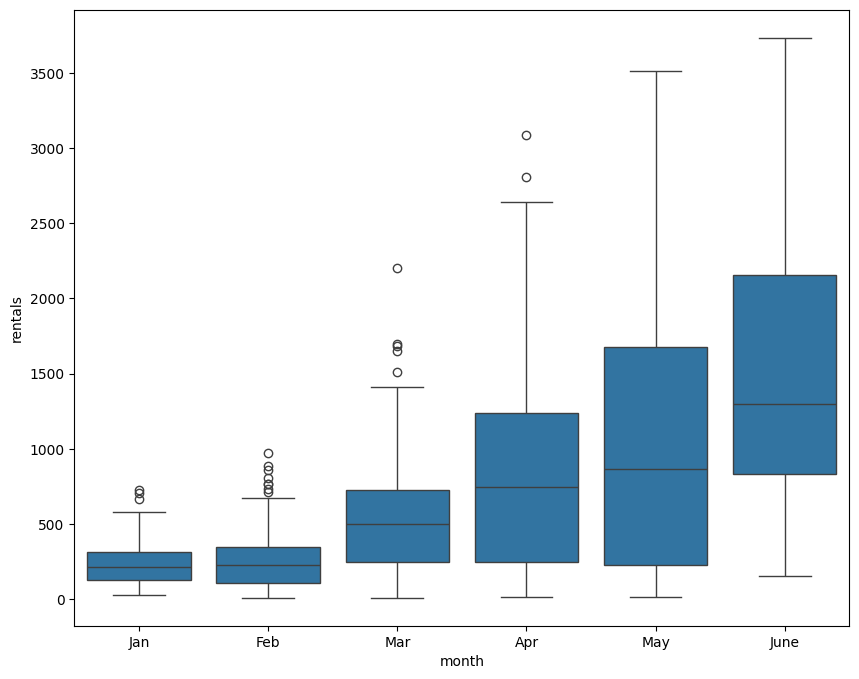

In [14]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'month',
                y    = 'rentals',
                data = bikerentals)

    plt.suptitle("")
    plt.show()

In [15]:
bikerentals["month"].value_counts()

,count
month,
Jan,189
May,181
Apr,173
Mar,166
Feb,162
June,158


YES TO ONE HOT

Seasonal activity detected
- data from Jan to June in the dataset

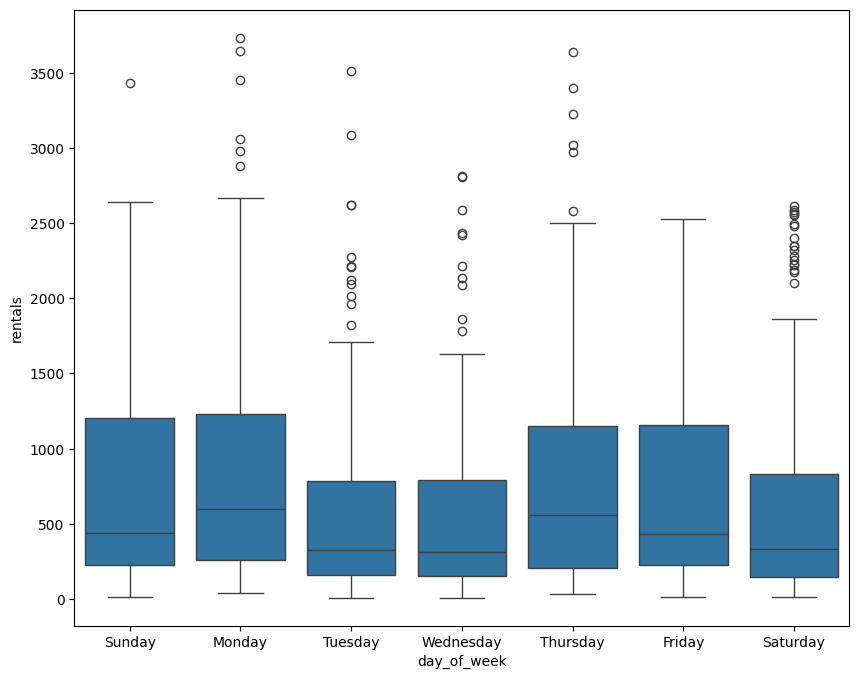

In [11]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'day_of_week',
                y    = 'rentals',
                data = bikerentals)

    plt.suptitle("")
    plt.show()

In [13]:
bikerentals["day_of_week"].value_counts()

,count
day_of_week,
Monday,161
Friday,161
Saturday,158
Thursday,149
Tuesday,138
Wednesday,136
Sunday,126


YES TO ONE HOT

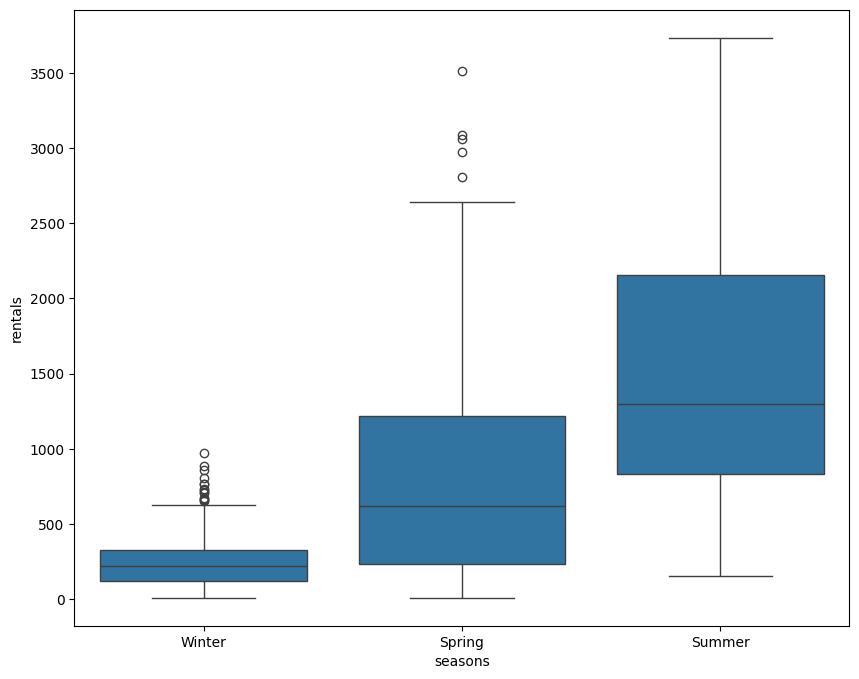

In [16]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'seasons',
                y    = 'rentals',
                data = bikerentals)

    plt.suptitle("")
    plt.show()

In [18]:
bikerentals["seasons"].value_counts()

,count
seasons,
Spring,520
Winter,351
Summer,158


### ONE HOT ENCODE

In [21]:
# one hot encoding categorical variables
one_hot_month = pd.get_dummies(data   = bikerentals['month'],
                          prefix = 'month',
                          dtype  = int)

one_hot_month.value_counts()

month_Apr  month_Feb  month_Jan  month_June  month_Mar  month_May
0          0          1          0           0          0            189
                      0          0           0          1            181
1          0          0          0           0          0            173
0          0          0          0           1          0            166
           1          0          0           0          0            162
           0          0          1           0          0            158
Name: count, dtype: int64

In [23]:
# one hot encoding categorical variables
one_hot_dow = pd.get_dummies(data   = bikerentals['day_of_week'],
                          prefix = 'dow',
                          dtype  = int)

one_hot_dow.value_counts()

dow_Friday  dow_Monday  dow_Saturday  dow_Sunday  dow_Thursday  dow_Tuesday  dow_Wednesday
1           0           0             0           0             0            0                161
0           1           0             0           0             0            0                161
            0           1             0           0             0            0                158
                        0             0           1             0            0                149
                                                  0             1            0                138
                                                                0            1                136
                                      1           0             0            0                126
Name: count, dtype: int64

In [26]:
# one hot encoding categorical variables
one_hot_seasons = pd.get_dummies(data   = bikerentals['seasons'],
                          prefix = 'seasons',
                          dtype  = int)

one_hot_seasons.value_counts()

seasons_Spring  seasons_Summer  seasons_Winter
1               0               0                 520
0               0               1                 351
                1               0                 158
Name: count, dtype: int64

In [29]:
bikerentals2 = bikerentals.join([one_hot_month, one_hot_dow, one_hot_seasons])
bikerentals2.head(n=5)

,month,day_of_week,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,...,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,seasons_Spring,seasons_Summer,seasons_Winter
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,...,0,0,0,1,0,0,0,0,0,1
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,...,0,0,0,1,0,0,0,0,0,1
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,...,0,0,0,1,0,0,0,0,0,1


In [35]:
# renaming channels and storing as diamonds (not diamonds2)
bikerentals2.rename(columns = {'dow_Monday': 'monday',
                            'dow_Tuesday': 'tuesday',
                            'dow_Wednesday': 'wednesday',
                            'dow_Thursday': 'thursday',
                            'dow_Friday': 'friday',
                            'dow_Saturday': 'saturday',
                            'dow_Sunday': 'sunday',
                            'month_Jan': 'jan',
                            'month_Feb': 'feb',
                            'month_Mar': 'mar',
                            'month_Apr': 'apr',
                            'month_May': 'may',
                            'month_June': 'jun',
                            'seasons_Spring': 'spring',
                            'seasons_Summer':'summer',
                            'seasons_Fall': 'fall',
                            'seasons_Winter': 'winter'
                            },
                inplace = True)


# checking results
bikerentals2.head(n = 5)

,month,day_of_week,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,...,friday,monday,saturday,sunday,thursday,tuesday,wednesday,spring,summer,winter
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,...,0,0,0,1,0,0,0,0,0,1
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,...,0,0,0,1,0,0,0,0,0,1
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,...,0,0,0,1,0,0,0,0,0,1
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,...,0,0,0,1,0,0,0,0,0,1


In [36]:
bikerentals2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  1029 non-null   object 
 1   day_of_week            1029 non-null   object 
 2   hour                   1029 non-null   int64  
 3   temperature            1029 non-null   float64
 4   humidity               1029 non-null   int64  
 5   wind_speed             1029 non-null   float64
 6   visibility             1029 non-null   int64  
 7   dew_point_temperature  1029 non-null   float64
 8   uv_index               1029 non-null   float64
 9   rainfall               1029 non-null   float64
 10  snowfall               1029 non-null   float64
 11  seasons                1029 non-null   object 
 12  holiday                1029 non-null   int64  
 13  rentals                1029 non-null   int64  
 14  apr                    1029 non-null   int64  
 15  feb 

YES TO SEASONS

In [1]:
corr_matrix = bikerentals.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

NameError: name 'bikerentals' is not defined